[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239469-lesson-2-breakpoints)

# Точки прерывания (Breakpoints)

## Итоги предыдущего раздела

Для реализации `human-in-the-loop` (человек в цикле) часто требуется видеть выводы графа по мере его выполнения.

Мы заложили основу для этого с помощью потоковой передачи.

## Цели текущего раздела

Теперь давайте обсудим мотивацию для `human-in-the-loop`:

(1) `Утверждение` - Мы можем прервать нашего агента, показать состояние пользователю и позволить пользователю принять действие

(2) `Отладка` - Мы можем перемотать граф, чтобы воспроизвести или избежать проблем

(3) `Редактирование` - Вы можете изменить состояние

LangGraph предлагает несколько способов получения или обновления состояния агента для поддержки различных рабочих процессов `human-in-the-loop`.

Сначала мы представим [точки прерывания](https://docs.langchain.com/oss/python/langgraph/interrupts#debugging-with-interrupts), которые предоставляют простой способ остановить граф на определенных шагах.

Мы покажем, как это позволяет реализовать `утверждение` пользователем.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_mistralai langgraph_sdk langgraph-prebuilt

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


## Точки прерывания для утверждения человеком

Давайте вернемся к простому агенту, с которым мы работали в Модуле 1.

Предположим, что мы обеспокоены использованием инструментов: мы хотим утверждать использование агентом любого из его инструментов.

Все, что нам нужно сделать, это просто скомпилировать граф с `interrupt_before=["tools"]`, где `tools` - это наш узел инструментов.

Это означает, что выполнение будет прервано перед узлом `tools`, который выполняет вызов инструмента.

In [4]:
from langchain_mistralai import ChatMistralAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatMistralAI(model="mistral-small-latest")
llm_with_tools = llm.bind_tools(tools)

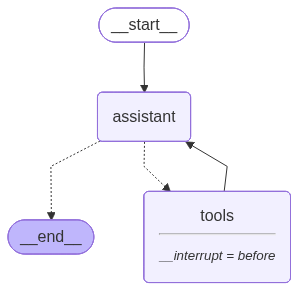

In [10]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [11]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (EeCRLk5Yy)
 Call ID: EeCRLk5Yy
  Args:
    a: 2
    b: 3


Мы можем получить состояние и посмотреть, какой узел должен быть вызван следующим.

Это удобный способ увидеть, что граф был прерван.

In [12]:
state = graph.get_state(thread)
state.next

('tools',)

Теперь покажем полезный приём.

Когда мы вызываем граф с `None`, он просто продолжит выполнение с последней контрольной точки состояния!

![breakpoints.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbae7985b747dfed67775d_breakpoints1.png)

Для ясности: LangGraph повторно выдаст текущее состояние, которое содержит `AIMessage` с вызовом инструмента.

Затем он продолжит выполнение следующих шагов в графе, начиная с узла инструментов.

Мы видим, что узел инструментов выполняется с этим вызовом, и результат передаётся обратно в чат-модель для получения окончательного ответа.

In [13]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (EeCRLk5Yy)
 Call ID: EeCRLk5Yy
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


HTTPStatusError: Error response 429 while fetching https://api.mistral.ai/v1/chat/completions: {"object":"error","message":"Service tier capacity exceeded for this model.","type":"service_tier_capacity_exceeded","param":null,"code":"3505"}

Теперь давайте объединим это с конкретным шагом подтверждения пользователем, который принимает пользовательский ввод.

In [15]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# Get user feedback
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (zwT8rlIXw)
 Call ID: zwT8rlIXw
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (zwT8rlIXw)
 Call ID: zwT8rlIXw
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

Multiplying 2 and 3 gives 6.


### Точки прерывания с LangGraph API

**⚠️ Внимание**

После создания этих видео мы обновили Studio, и теперь её можно запускать локально и открывать в браузере. Это предпочтительный способ работы со Studio вместо использования Desktop App, показанного в видео. Теперь она называется _LangSmith Studio_ вместо _LangGraph Studio_. Подробные инструкции по настройке доступны в руководстве "Начало работы" в начале курса. Описание Studio можно найти [здесь](https://docs.langchain.com/langsmith/studio), а конкретные детали по локальному развертыванию — [здесь](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).

Чтобы запустить локальный сервер разработки, выполните следующую команду в терминале в директории `/studio` этого модуля:

```
langgraph dev
```

Вы должны увидеть следующий вывод:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Откройте браузер и перейдите по URL-адресу **Studio UI**, указанному выше.

LangGraph API [поддерживает точки прерывания](https://docs.langchain.com/langsmith/add-human-in-the-loop).

In [16]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [17]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Как показано выше, мы можем добавить `interrupt_before=["node"]` при компиляции графа, который работает в Studio.

Однако при работе с API вы также можете передать `interrupt_before` непосредственно в метод stream.

In [18]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'e94f337e-2809-4a82-acb3-0a159a37c8f8'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'lLtG2uPiD', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, 'index': 0}]}, 'response_metadata': {'token_usage': {'prompt_tokens': 273, 'total_tokens': 290, 'completion_tokens': 17}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--8c941388-a618-4575-b8ea-2ef0cb07e8bf-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'lLtG2uPiD', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_met

Теперь мы можем продолжить выполнение с точки прерывания, как мы делали ранее, передав `thread_id` и `None` в качестве входных данных!

In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=None,
    stream_mode="values",
    interrupt_before=["tools"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'lLtG2uPiD', 'function': {'name': 'multiply', 'arguments': '{"a": 2, "b": 3}'}, 'index': 0}]}, 'response_metadata': {'token_usage': {'prompt_tokens': 273, 'total_tokens': 290, 'completion_tokens': 17}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'tool_calls', 'model_provider': 'mistralai'}, 'type': 'ai', 'name': None, 'id': 'lc_run--8c941388-a618-4575-b8ea-2ef0cb07e8bf-0', 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'lLtG2uPiD', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 273, 'output_tokens': 17, 'total_tokens': 290}}
--------------------------------------------------
Receiving new event of type: values...
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'na